# Dec 5th, 2022 (SLC: export OCs)

**Motivation**: save OCs in 3D CCFv3 space, export both dense and binarized <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn)

## Save dir

In [4]:
save_dir = pjoin(fig_dir, f"K{num_k}", 'export')
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs/K7/export

## Results (OCs)

In [5]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=None,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 11.1 s, sys: 3.24 s, total: 14.3 s
Wall time: 14.5 s


['bt_dict', 'props_bo', 'props_ca', 'pi_sorted', 'sim', 'sim_overall']

### Show OCs

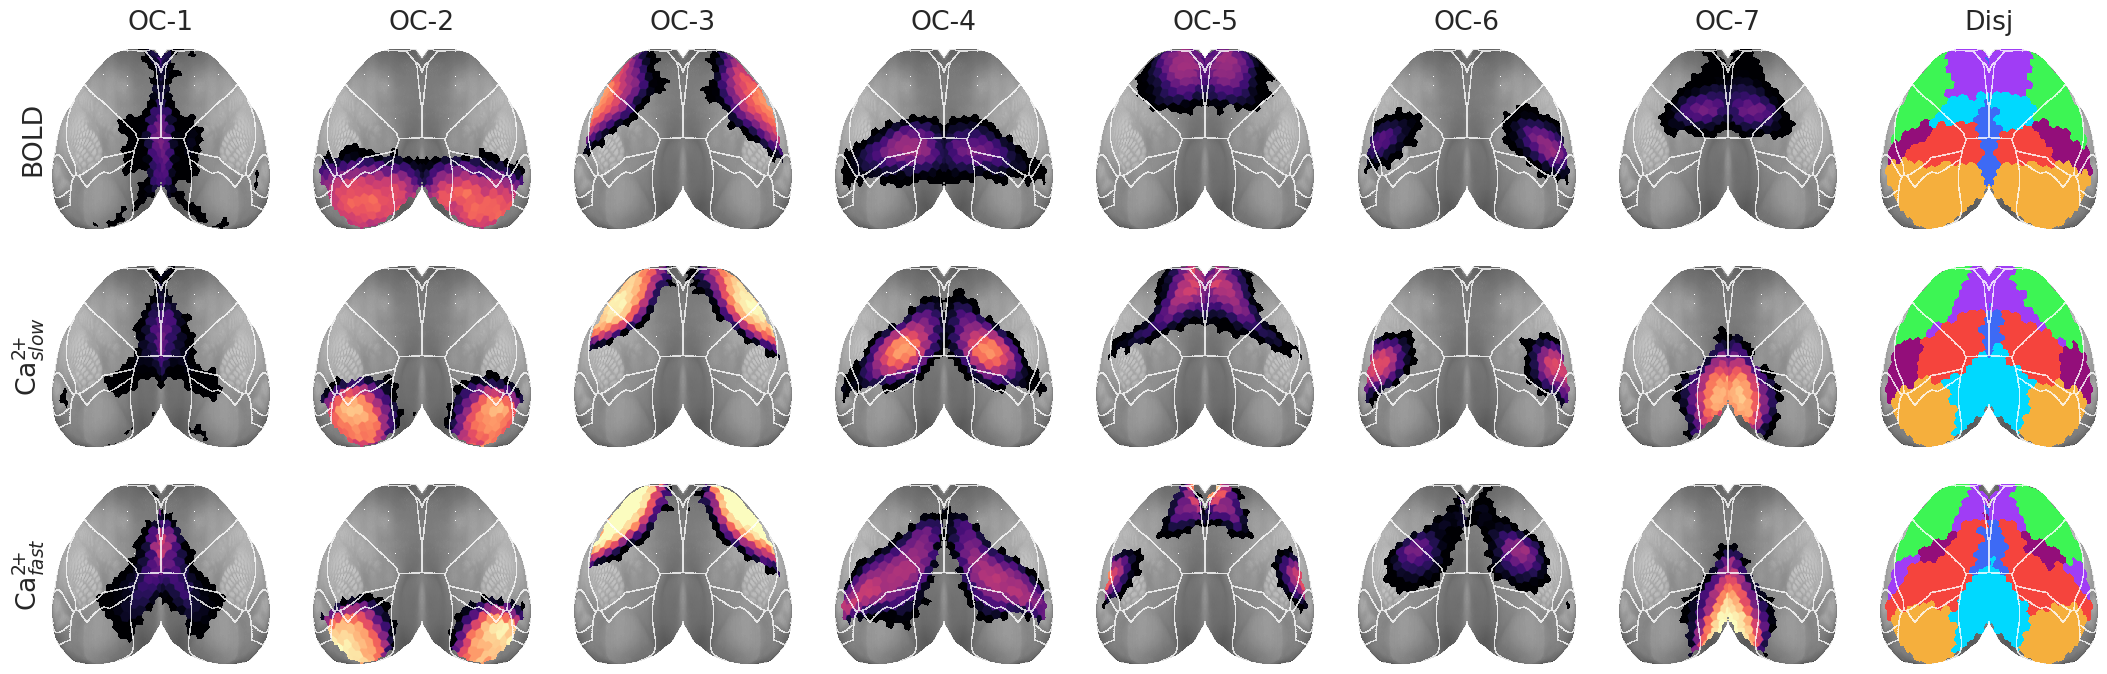

In [6]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

### Bring to CCFv3

In [7]:
pi = results['pi_sorted'][BOLD].copy()
pi = np.concatenate([pi, bt.get_disjoint_community(pi).reshape(1, -1)])
pi.shape

(8, 542)

In [8]:
pi_ccf = np.zeros((len(pi), *mice.parcel['cortex'].shape))
for n, lbl in mice.node_lookup['ca2'].items():
    r = mice.parcel.encode(lbl)
    pi_ccf[:, mice.parcel['cortex'] == r] = pi[:, [n]]
pi_ccf.shape

(8, 132, 80, 114)

#### Save numpy

In [9]:
_ = save_obj(
    obj=pi_ccf,
    file_name='pi_ccf',
    save_dir=save_dir,
    mode='npy',
)

[PROGRESS] 'pi_ccf.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs/K7/export

#### Save each as NIFTI img

In [10]:
from register.register import Register, reset_ants_img
reg = Register(mice)
reg.mi_base = ants.image_mutual_information(
    image1=reg.nissl, image2=reg.nissl)

reg.nissl

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (132, 80, 114)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [11]:
for i, x in enumerate(pi_ccf, start=1):
    img = reset_ants_img(
        img=x,
        spacing=reg.nissl.spacing,
        origin=reg.nissl.origin,
        dtype=float,
    )
    name = f"{'Disj' if i == num_k + 1 else f'OC{i}'}.nii.gz"
    name = f"CCF_{name}"
    print(f"[Progress] {name} saved")
    ants.image_write(img, pjoin(save_dir, name))

[Progress] CCF_OC1.nii.gz saved

[Progress] CCF_OC2.nii.gz saved

[Progress] CCF_OC3.nii.gz saved

[Progress] CCF_OC4.nii.gz saved

[Progress] CCF_OC5.nii.gz saved

[Progress] CCF_OC6.nii.gz saved

[Progress] CCF_OC7.nii.gz saved

[Progress] CCF_Disj.nii.gz saved

## Bring to N162

### N162 --> CCFv3 warp

In [12]:
tx, tx_aff = reg.load_tx('N162', 'bold', is_inv=False)
tx

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF3d_ants-fwd.nii.gz',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF3d_ants-fwd.mat'
]

In [13]:
affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.nissl,
    interpolation='linear',
)
warped = ants.apply_transforms(
    fixed=reg.nissl,
    moving=affined,
    transformlist=tx,
    interpolator='linear',
)

In [14]:
mi_aff = ants.image_mutual_information(
    image1=reg.nissl, image2=affined)
mi_syn = ants.image_mutual_information(
    image1=reg.nissl, image2=warped)
mi_aff /= reg.mi_base
mi_syn /= reg.mi_base

mi_aff, mi_syn

(0.41501759487481366, 0.5196550982911954)

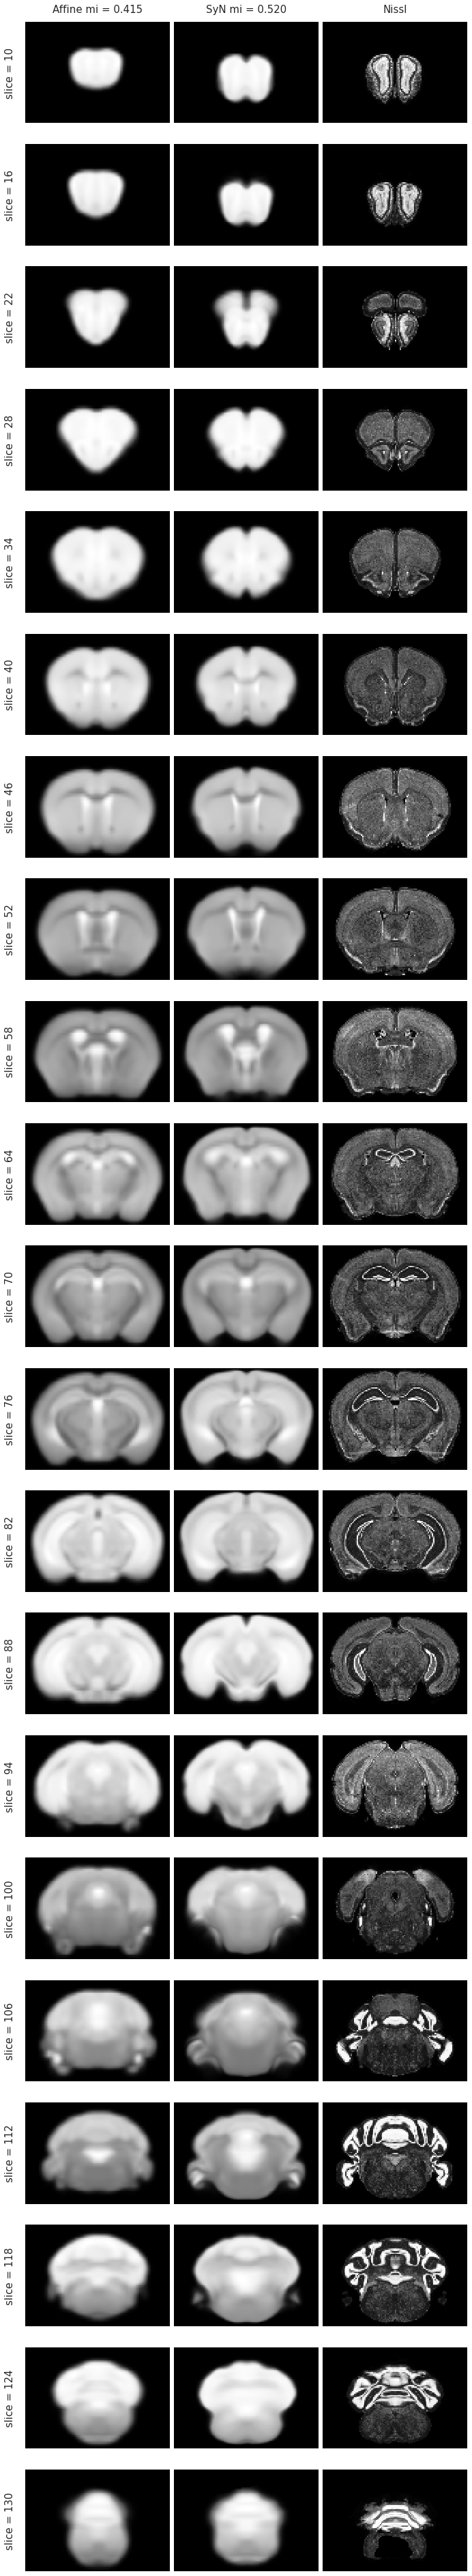

In [15]:
slices = range(10, 132, 6)
fig, axes = create_figure(len(slices), 3, (9.5, 2.5 * len(slices)), 'all', 'all', constrained_layout=True)

for i, ii in enumerate(slices):
    axes[i, 0].imshow(affined[ii], cmap='Greys_r')
    axes[i, 1].imshow(warped[ii], cmap='Greys_r')
    axes[i, 2].imshow(reg.nissl[ii], cmap='Greys_r')

    if i == 0:
        axes[i, 0].set_title(f'Affine mi = {mi_aff:0.3f}', y=1.05, fontsize=15)
        axes[i, 1].set_title(f'SyN mi = {mi_syn:0.3f}', y=1.05, fontsize=15)
        axes[i, 2].set_title('Nissl', y=1.05, fontsize=15)
    
    axes[i, 0].set_ylabel(f"slice = {ii}", labelpad=15, fontsize=15)
        
remove_ticks(axes)
plt.show()

### CCFv3 -- > N162 warp

In [16]:
tx, tx_aff = reg.load_tx('N162', 'bold', is_inv=True)
tx_aff_inv = tx_aff.invert()
tx

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF3d_ants-inv.mat',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF3d_ants-inv.nii.gz'
]

In [17]:
affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.nissl,
    interpolation='linear',
)
nissl_1 = ants.apply_transforms(
    fixed=affined,
    moving=reg.nissl,
    transformlist=tx,
    interpolator='linear',
)
nissl_2 = tx_aff_inv.apply_to_image(
    image=nissl_1,
    reference=reg.in_house,
    interpolation='linear',
)

In [18]:
mi_base = ants.image_mutual_information(
    image1=reg.in_house, image2=reg.in_house)

mi_syn = ants.image_mutual_information(
    image1=reg.in_house, image2=nissl_2)
mi_syn /= mi_base

mi_syn

0.5380480663140864

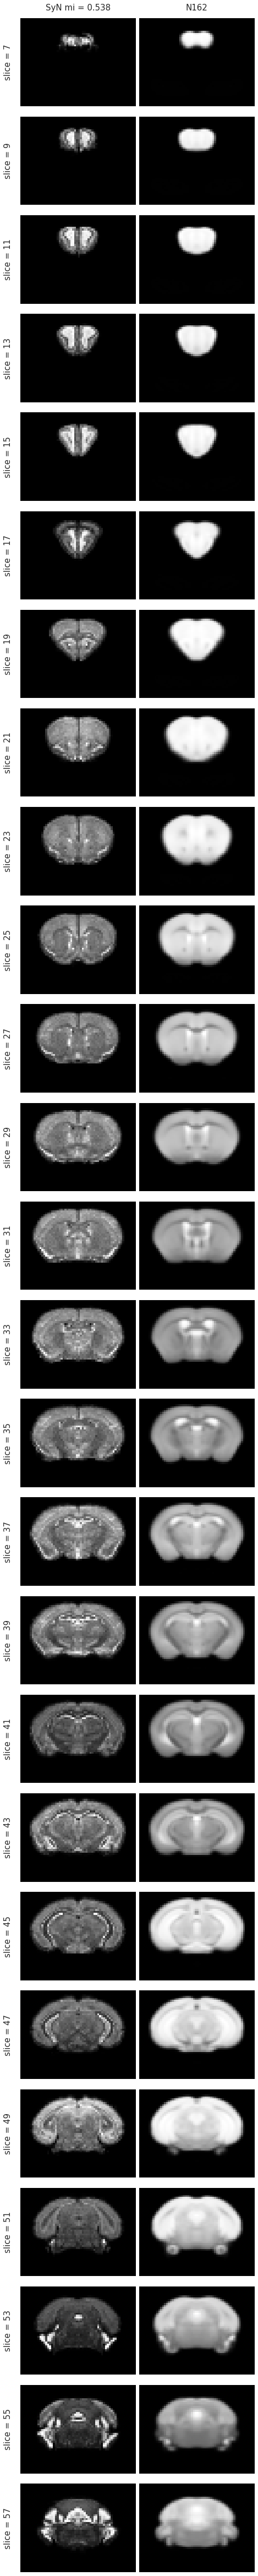

In [19]:
slices = range(7, 58, 2)
fig, axes = create_figure(len(slices), 2, (6.4, 2.5 * len(slices)), 'all', 'all', constrained_layout=True)

for i, ii in enumerate(slices):
    axes[i, 0].imshow(nissl_2[ii], cmap='Greys_r')
    axes[i, 1].imshow(reg.in_house[ii], cmap='Greys_r')

    if i == 0:
        axes[i, 0].set_title(f'SyN mi = {mi_syn:0.3f}', y=1.05, fontsize=15)
        axes[i, 1].set_title('N162', y=1.05, fontsize=15)
    
    axes[i, 0].set_ylabel(f"slice = {ii}", labelpad=15, fontsize=15)
        
remove_ticks(axes)
plt.show()

In [20]:
ctx_1 = ants.apply_transforms(
    fixed=affined,
    moving=reg.img_in_ccf(mice.parcel['cortex']),
    transformlist=tx,
    interpolator='genericLabel',
)
ctx_2 = tx_aff_inv.apply_to_image(
    image=ctx_1,
    reference=reg.in_house,
    interpolation='multilabel',
)

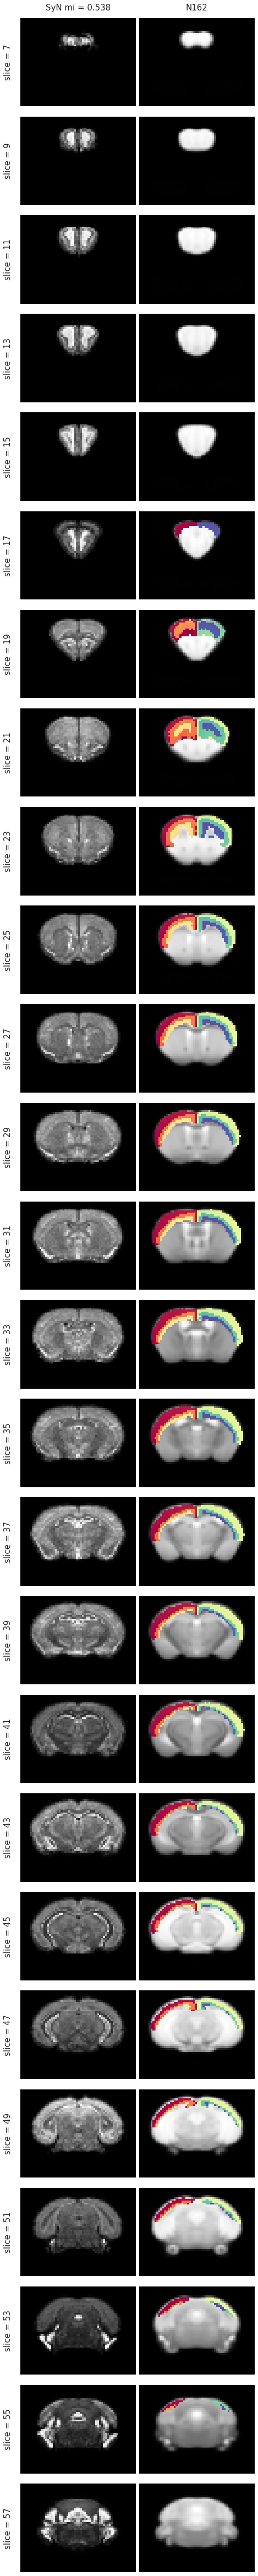

In [21]:
slices = range(7, 58, 2)
fig, axes = create_figure(len(slices), 2, (6.4, 2.5 * len(slices)), 'all', 'all', constrained_layout=True)

for i, ii in enumerate(slices):
    axes[i, 0].imshow(nissl_2[ii], cmap='Greys_r')
    axes[i, 1].imshow(reg.in_house[ii], cmap='Greys_r')
    axes[i, 1].imshow(mwh(ctx_2[ii] == 0, ctx_2[ii]), cmap='Spectral')

    if i == 0:
        axes[i, 0].set_title(f'SyN mi = {mi_syn:0.3f}', y=1.05, fontsize=15)
        axes[i, 1].set_title('N162', y=1.05, fontsize=15)
    
    axes[i, 0].set_ylabel(f"slice = {ii}", labelpad=15, fontsize=15)
        
remove_ticks(axes)
plt.show()

<matplotlib.image.AxesImage object at 0x7fb4f49f5dc0>

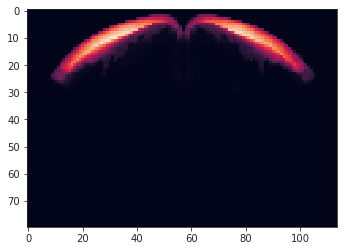

In [22]:
plt.imshow(pi_ccf[1].mean(0))

In [23]:
x_1 = ants.apply_transforms(
    fixed=affined,
    moving=reg.img_in_ccf(pi_ccf[1], dtype=float),
    transformlist=tx,
    interpolator='linear',
)
x_2 = tx_aff_inv.apply_to_image(
    image=x_1,
    reference=reg.in_house,
    interpolation='linear',
)

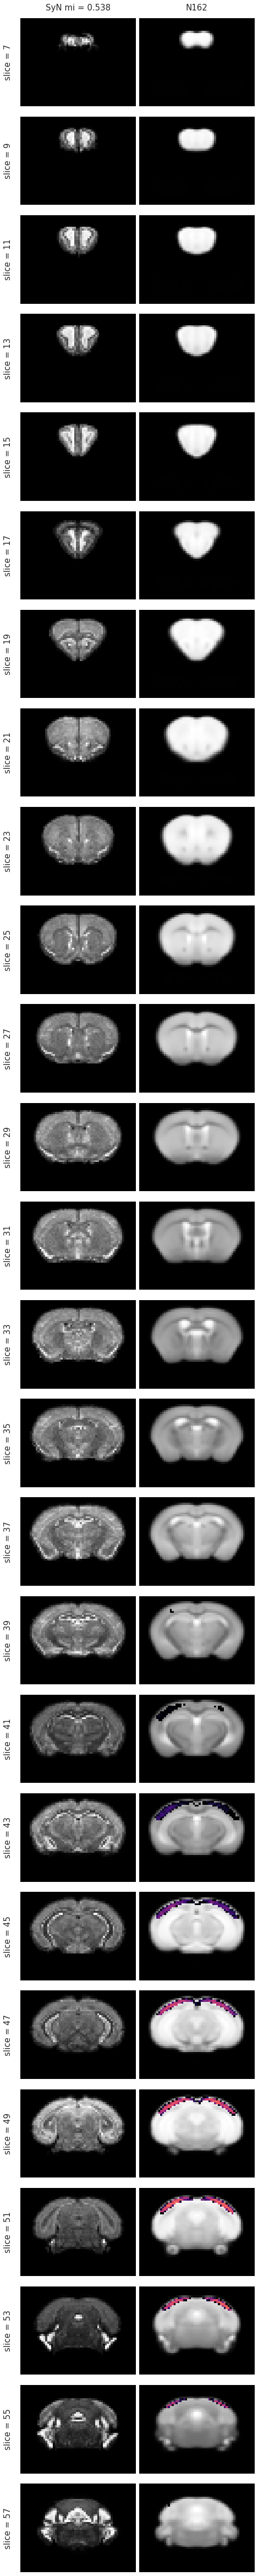

In [24]:
slices = range(7, 58, 2)
fig, axes = create_figure(len(slices), 2, (6.4, 2.5 * len(slices)), 'all', 'all', constrained_layout=True)

for i, ii in enumerate(slices):
    axes[i, 0].imshow(nissl_2[ii], cmap='Greys_r')
    axes[i, 1].imshow(reg.in_house[ii], cmap='Greys_r')
    axes[i, 1].imshow(mwh(x_2[ii] < 1 / num_k, x_2[ii]), cmap='magma', vmin=0.2, vmax=0.9)

    if i == 0:
        axes[i, 0].set_title(f'SyN mi = {mi_syn:0.3f}', y=1.05, fontsize=15)
        axes[i, 1].set_title('N162', y=1.05, fontsize=15)
    
    axes[i, 0].set_ylabel(f"slice = {ii}", labelpad=15, fontsize=15)
        
remove_ticks(axes)
plt.show()

In [25]:
for i, x in enumerate(pi_ccf, start=1):
    x_1 = ants.apply_transforms(
        fixed=affined,
        moving=reg.img_in_ccf(x, dtype='uint32' if i == num_k + 1 else float),
        transformlist=tx,
        interpolator='genericLabel' if i == num_k + 1 else 'linear',
    )
    x_2 = tx_aff_inv.apply_to_image(
        image=x_1,
        reference=reg.in_house,
        interpolation='multilabel' if i == num_k + 1 else 'linear',
    )
    x_3 = reg.to_lps(x_2, spacing=0.2, dtype='uint32' if i == num_k + 1 else float)

    name = f"{'Disj' if i == num_k + 1 else f'OC{i}'}.nii.gz"
    name = f"N162_{name}"
    print(f"[Progress] {name} saved")
    ants.image_write(x_3, pjoin(save_dir, name))

[Progress] N162_OC1.nii.gz saved

[Progress] N162_OC2.nii.gz saved

[Progress] N162_OC3.nii.gz saved

[Progress] N162_OC4.nii.gz saved

[Progress] N162_OC5.nii.gz saved

[Progress] N162_OC6.nii.gz saved

[Progress] N162_OC7.nii.gz saved

[Progress] N162_Disj.nii.gz saved

<matplotlib.image.AxesImage object at 0x7fb4f3774f10>

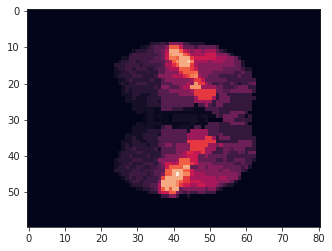

In [26]:
plt.imshow(x_3.mean(1))

## Draft (ignore below)

In [160]:
obj = reg._apply_tx_obj2lps(
    obj={'cortex': mice.parcel['cortex']},
    name=reg.in_house_name,
    moving=nissl_aff,
    moving_orig=reg.nissl,
    tx_aff=tx_aff_inv,
    tx=tx,
    use_mm=True,
    save_results=False,
)
list(obj)

['cortex', 'CH', 'brain', 'misc', 'iso', 'hemis']

<matplotlib.image.AxesImage object at 0x7fde8414cdc0>

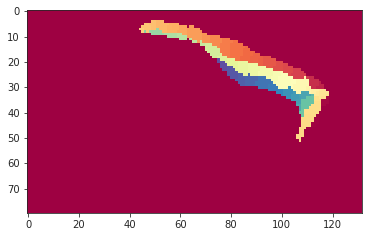

In [167]:
plt.imshow(obj['cortex'][40], cmap='Spectral')

In [122]:
obj = reg._apply_tx_obj2lps(
    obj={'cortex': mice.parcel['cortex']},
    name=reg.in_house_name,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
    use_mm=True,
    save_results=False,
)

In [123]:
list(obj)

['cortex', 'CH', 'brain', 'misc', 'iso', 'hemis']

<matplotlib.image.AxesImage object at 0x7fde8472ff10>

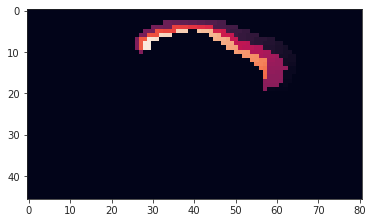

In [127]:
plt.imshow(obj['cortex'][20])